# 1.可视化CNN卷积核

vgg11 的第三层卷积核可视化

In [ ]:
import torch
from torchvision.models import vgg11

model = vgg11(pretrained=True)
print(dict(model.features.named_children()))

{'0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '1': ReLU(inplace=True), '2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '3': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '4': ReLU(inplace=True), '5': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '6': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '7': ReLU(inplace=True), '8': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '9': ReLU(inplace=True), '10': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '11': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '12': ReLU(inplace=True), '13': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '14': ReLU(inplace=True), '15': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '16': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '17'

vgg11的第三层卷积层，一共有128*64个卷积核，所以可视化会有128个图，每个图有64个卷积核，这里只可视化一部分

torch.Size([128, 64, 3, 3])


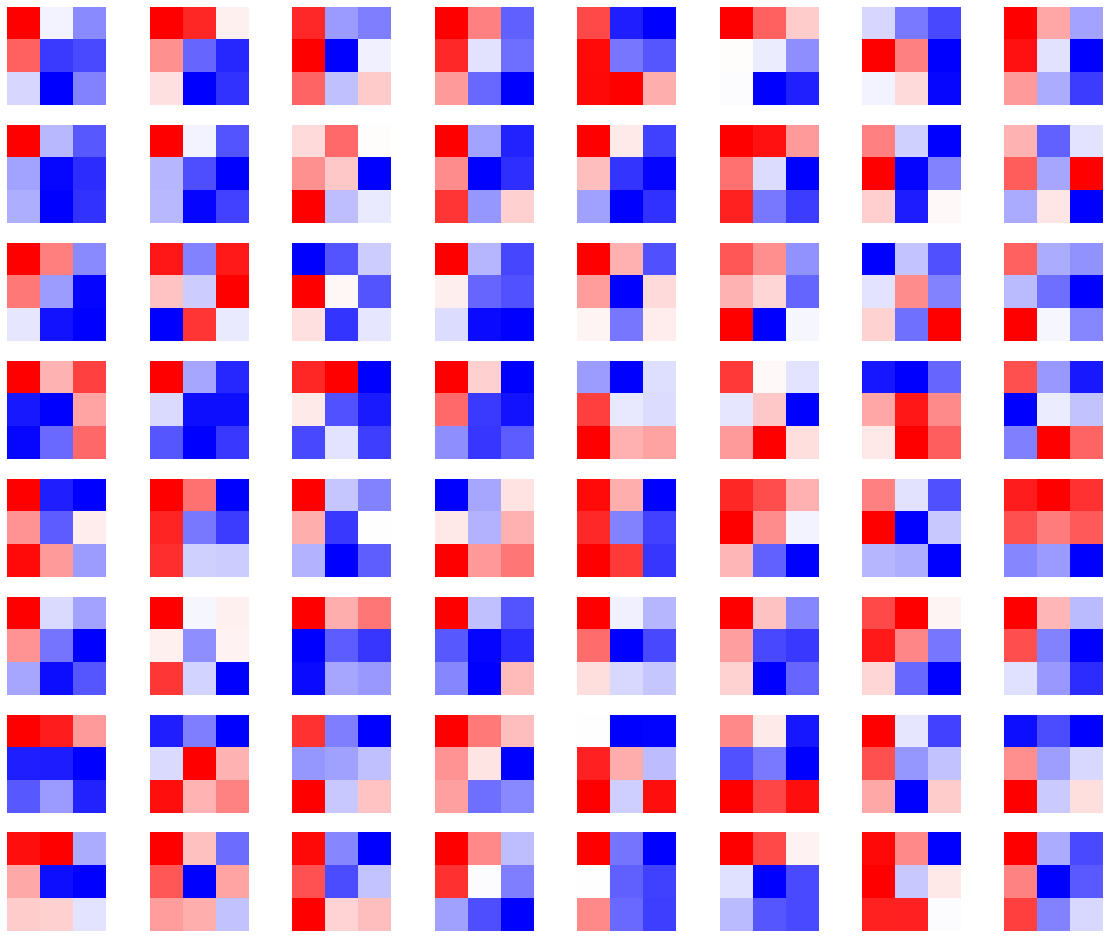

In [ ]:
import matplotlib.pyplot as plt
conv1 = dict(model.features.named_children())['3']
kernel_set = conv1.weight.detach()
num = len(conv1.weight.detach())
print(kernel_set.shape)
for i in range(0,num):
    i_kernel = kernel_set[i]
    plt.figure(figsize=(20, 17))
    if (len(i_kernel)) > 1:
        for idx, filer in enumerate(i_kernel):
            plt.subplot(8, 8, idx+1) 
            plt.axis('off')
            plt.imshow(filer[ :, :].detach(),cmap='bwr')
    break # 可视化64个卷积核

total of number of filter :  64 torch.Size([64, 3, 11, 11])


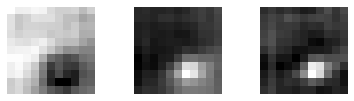

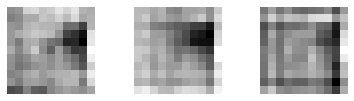

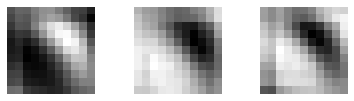

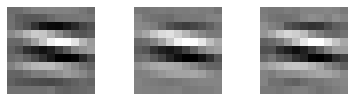

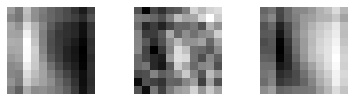

In [ ]:
from torchvision.models import alexnet
model = alexnet(pretrained=True)
conv1 = dict(model.features.named_children())['0']
localw = conv1.weight.detach() 
print("total of number of filter : ", len(localw), localw.shape)
num = len(localw)
for i in range(num):
    localw0 = localw[i]
    # print(localw0.shape)    
    # mean of 3 channel.
    # localw0 = torch.mean(localw0,dim=0)
    # there should be 3(3 channels) 11 * 11 filter.
    plt.figure(figsize=(20, 17))
    if (len(localw0)) > 1:
        for idx, filer in enumerate(localw0):
            plt.subplot(9, 9, idx+1) 
            plt.axis('off')
            plt.imshow(filer[ :, :].detach(),cmap='gray')
    if (i+1)%5 == 0:
        break # 只输出10 个 3x11x11的卷积核

# 2.CNN class activation map可视化方法

class activation map （CAM）的作用是判断哪些变量对模型来说是重要的，在CNN可视化的场景下，即判断图像中哪些像素点对预测结果是重要的。除了确定重要的像素点，人们也会对重要区域的梯度感兴趣，因此在CAM的基础上也进一步改进得到了Grad-CAM（以及诸多变种）。CAM和Grad-CAM的示例如下图所示：

![在这里插入图片描述](https://img-blog.csdnimg.cn/f6448184fae64d5c8ef8f52cbafe040e.png#pic_center)

相比可视化卷积核与可视化特征图，CAM系列可视化更为直观，能够一目了然地确定重要区域，进而进行可解释性分析或模型优化改进。CAM系列操作的实现可以通过开源工具包pytorch-grad-cam来实现。

- 安装

```bash
pip install grad-cam
```

In [ ]:
!pip install grad-cam

     |████████████████████████████████| 4.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 21.0 MB 1.6 MB/s 
     |████████████████████████████████| 750.6 MB 8.0 kB/s 
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=51a762a55f2c2f9154bb59430f181dcacda79cd3eb8b37125ef268fbcb3b13ef
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam
  Attempting uninstall: torch
    Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0
    Uninstalling torchvision-0.6.0:
      Successfully uninstalled torchvision-0.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that

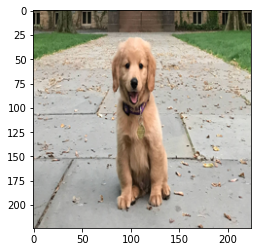

In [ ]:
import torch
from torchvision.models import vgg11,resnet18,resnet101,resnext101_32x8d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

model = vgg11(pretrained=True)
img_path = 'img/dog.png'
# resize操作是为了和传入神经网络训练图片大小一致
img = Image.open(img_path).resize((224,224))
# 需要将原始图片转为np.float32格式并且在0-1之间 
rgb_img = np.float32(img)/255
plt.imshow(img)

<class 'numpy.ndarray'>


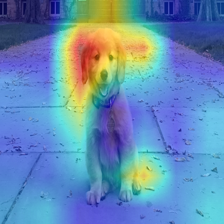

In [ ]:
from pytorch_grad_cam import GradCAM,ScoreCAM,GradCAMPlusPlus,AblationCAM,XGradCAM,EigenCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms.functional as F


target_layers = [model.features[-1]]#如果传入多个layer，cam输出结果将会取均值
img_tensor = F.to_tensor(img)
img_tensor=img_tensor.unsqueeze(0)#变成BCHW的数据，B==1; squeeze

preds = 999

# 选取合适的类激活图，但是ScoreCAM和AblationCAM需要batch_size
cam = GradCAM(model=model,target_layers=target_layers)
targets = [ClassifierOutputTarget(preds)]   

# 上方preds需要设定，比如ImageNet有1000类，这里可以设为200
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)


# 3.使用FlashTorch快速实现CNN可视化

其实随着时代的发展，我们也不需要一个一个写代码去可视化了，也封装成一个一个的库了。随着PyTorch社区的努力，目前已经有不少开源工具能够帮助我们快速实现CNN可视化。这里我们介绍其中的一个——[FlashTorch](https://github.com/MisaOgura/flashtorch)。

（注：使用中发现该package对环境有要求，如果下方代码运行报错，请参考作者给出的配置或者Colab运行环境：https://github.com/MisaOgura/flashtorch/issues/39）


```bash
pip install flashtorch
```

很奇怪的是，这里面一定需要对于的版本，要不然报错

In [ ]:
# Install flashtorch

!pip install flashtorch torch==1.5.0 torchvision==0.6.0 -U

  Using cached torch-1.5.0-cp37-cp37m-manylinux1_x86_64.whl (752.0 MB)
  Using cached torchvision-0.6.0-cp37-cp37m-manylinux1_x86_64.whl (6.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0 which is incompatible.
grad-cam 1.3.7 requires torch>=1.7.1, but you have torch 1.5.0 which is incompatible.
grad-cam 1.3.7 requires torchvision>=0.8.2, but you have torchvision 0.6.0 which i

In [ ]:
# Download example images
# !mkdir -p img

# !wget -nv \
#     https://github.com/MisaOgura/flashtorch/raw/master/examples/images/great_grey_owl.jpg \
#     https://github.com/MisaOgura/flashtorch/raw/master/examples/images/peacock.jpg        \
#     https://github.com/MisaOgura/flashtorch/raw/master/examples/images/toucan.jpg         \
#     -P /content/img

## 可视化梯度

In [ ]:
# Download example images
# !mkdir -p images
# !wget -nv \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/great_grey_owl.jpg \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/peacock.jpg   \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/toucan.jpg    \
#    -P img

import matplotlib.pyplot as plt
import torchvision.models as models
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

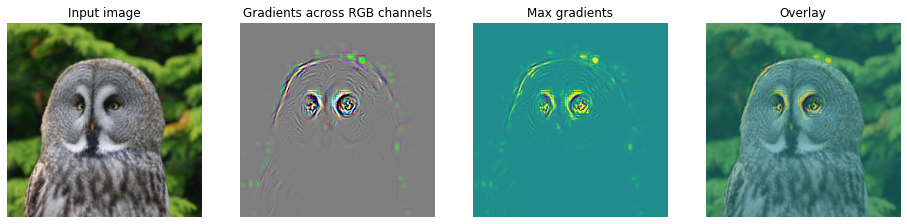

In [ ]:
model = models.alexnet(pretrained=True)
backprop = Backprop(model)

image = load_image('img/great_grey_owl.jpg')
owl = apply_transforms(image)

target_class = 24

backprop.visualize(owl, target_class, guided=True, use_gpu=True)

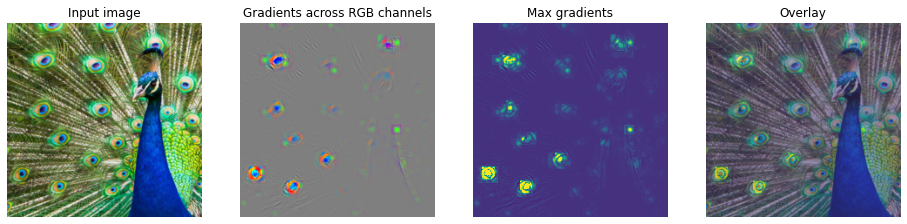

In [ ]:
peacock = apply_transforms(load_image('img/peacock.jpg'))
backprop.visualize(peacock, 84, guided=True, use_gpu=True)

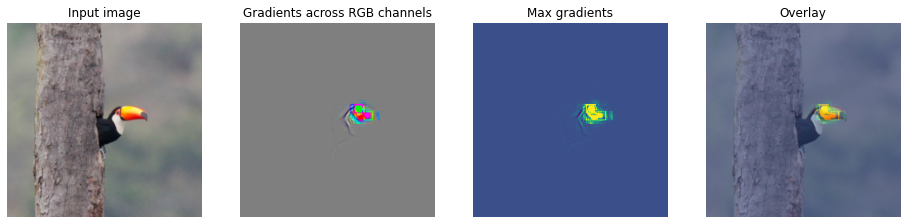

In [ ]:
toucan = apply_transforms(load_image('img/toucan.jpg'))
backprop.visualize(toucan, 96, guided=True, use_gpu=True)

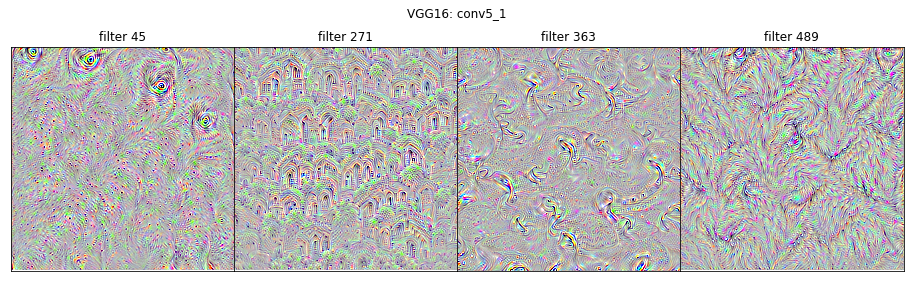

In [ ]:
import torchvision.models as models
from flashtorch.activmax import GradientAscent

model = models.vgg16(pretrained=True)
g_ascent = GradientAscent(model.features)

# specify layer and filter info
conv5_1 = model.features[24]
conv5_1_filters = [45, 271, 363, 489]

g_ascent.visualize(conv5_1, conv5_1_filters, title="VGG16: conv5_1")